# **Title**

## **Introduction**
### Background Information
In this project, we are exploring data gathered from Minecraft players. The Minecraft server is set up by a computer science research group led by Frank Wood, and they are trying to figure out what kind of players should be targeted for recruiting based on whose most likely to contribute largest amounts of data.

### Question of the Project
Based on the goals of the research group, the question we are trying to answer is: **Can Player Age Predict the Total Number of Gameplay Sessions Contributed?**

### Loading Data 
Below is the initial loading of both datasets, as well as summary() being run on both.

In [13]:
library(tidyverse)
players_data <- read_csv("Data/players.csv")
head(players_data)
summary(players_data)
sessions_data <- read_csv("Data/sessions.csv")
head(sessions_data)
summary(sessions_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

## The Datasets: player.csv and sessions.csv
The data sets are provided as follows

#### **players.csv** is a list of all unique players, including data about each player. 
We use the data in the age column as an explanatory variable in our question.
  
### players_data Summary
In the players.csv dataset, there are
* 196 observations
* 7 variables
* played_hours and possibly hashed_email is gathered through server data, and every other variable likely through registration/survey
  

##### Variables Summary
The 7 variables are 
1. experience
   * character variable with 5 categories: "Veteran", "Pro", "Amateur", "Regular", and "Beginning", indicating individuals' MineCraft experience level
<br><br>     
2. subscribe
   * logical variable (true or false) indicating player's subscription to a newsletter
   * there are many more subscribers (144) to non-subscribers (52)
<br><br>
3. hashedEmail
   * character variable that reports the player's censored email address
   * **potential issue:** undecipherable to reader
<br><br>
4. played_hours
    * a double variable reporting an individual's played hours of MineCraft
    * **mean played_hours: 5.84** 
<br><br>
5. name
   * character variable of player's name
<br><br>
6. gender
   * character variable representing the player's gender: "Male", "Female", "Agender", "Prefer not to say", "Non-binary","Other" and "Two-Spirited."
   * **potential issue:** must become factors
<br><br>
7. age
    * double variable reporting the individual's age in years
    * **potential issue:** NA values must be filtered out
    * **mean age: 21.14**
<br><br>

#### **sessions.csv** is a list of individual play sessions by each player, including data about the session. 
We used data from the hashedEmail column to serve as the response variable, an individual's number of game sessions played, for the predictor, age. 
### sessions_data Summary
In the sessions.csv dataset, there are
* 1535 observations
* 5 variables
* all data came from the MineCraft server
  

##### Variables Summary
The 5 variables are 
1. hashedEmail (repeat from players.csv)
   * character variable that reports the player's censored email address
<br><br>
2. start_time and end_time
    * both character variables
    * **potential issues**: not tidy data (characters), but understandable to reader
<br><br>
3. original_start_time and original_end_time
     * both double variables
     * **potential issues**: unintelligible to reader
    * **mean original_start_time: 1.719e+12**
    * **mean original_end_time: 1.719e+12**
    * **potential issue:** NA values present in original_end_time


## Methods & Results

- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
    - loads data (Griffin)
    - wrangles and cleans the data to the format necessary for the planned analysis (Ryan)
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis (Ryan)
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis (Ryan)
    - performs the data analysis (Griffin)
    - creates a visualization of the analysis (TBD)
- note: all figures should have a figure number and a legend

In [14]:
library(tidyverse)
library(tidymodels)
library(knitr)
library(repr)

### Data Wrangling and Cleaning

In [15]:
# Count sessions per player
session_counts <- sessions_data |>
  filter(!is.na(end_time)) |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

# Join with player data and clean
analysis_data <- players_data |>
  left_join(session_counts, by = "hashedEmail") |>
  mutate(
    num_sessions = replace_na(num_sessions, 0),
    Age = as.numeric(Age)
  ) |>
  filter(!is.na(Age))

# Display summary
cat("Cleaned dataset contains", nrow(analysis_data), "players with complete age data\n")
cat("Players with at least one session:", sum(analysis_data$num_sessions > 0), "\n")

Cleaned dataset contains 194 players with complete age data
Players with at least one session: 123 


We performed the following data wrangling steps to prepare our dataset for analysis:

1. **Filtered incomplete sessions**: We removed sessions with missing end times from the sessions dataset
2. **Counted sessions per player**: We grouped the sessions data by each player's hashed email and counted how many sessions they had
3. **Joined datasets**: We combined the session counts with the player demographic data using the hashed email as the key
4. **Handled missing sessions**: Players who had no recorded sessions were assigned a count of 0
5. **Removed missing age values**: We filtered out players who did not have age data, leaving us with 194 players for analysis

This cleaned dataset contains all the information needed to explore whether player age can predict the number of gameplay sessions contributed.

### Summary Statistics for Exploratory Data Analysis

In [16]:
# Calculate summary statistics for Age
age_summary <- data.frame(
  Variable = "Age (years)",
  Mean = round(mean(analysis_data$Age, na.rm = TRUE), 2),
  SD = round(sd(analysis_data$Age, na.rm = TRUE), 2),
  Min = round(min(analysis_data$Age, na.rm = TRUE), 2),
  Max = round(max(analysis_data$Age, na.rm = TRUE), 2)
)

# Calculate summary statistics for Number of Sessions
sessions_summary <- data.frame(
  Variable = "Number of Sessions",
  Mean = round(mean(analysis_data$num_sessions), 2),
  SD = round(sd(analysis_data$num_sessions), 2),
  Min = round(min(analysis_data$num_sessions), 2),
  Max = round(max(analysis_data$num_sessions), 2)
)

# Combine into one table
summary_table <- rbind(age_summary, sessions_summary)
kable(summary_table, caption = "Table 1: Summary Statistics for Age and Session Count")

# Additional relevant statistics
cat("\n**Key Statistics:**\n")
cat("- Correlation between Age and Sessions:", 
    round(cor(analysis_data$Age, analysis_data$num_sessions), 3), "\n")
cat("- Percentage of players with 0 sessions:", 
    round(sum(analysis_data$num_sessions == 0) / nrow(analysis_data) * 100, 1), "%\n")
cat("- Percentage of players with 10+ sessions:", 
    round(sum(analysis_data$num_sessions >= 10) / nrow(analysis_data) * 100, 1), "%\n")



Table: Table 1: Summary Statistics for Age and Session Count

|Variable           |  Mean|    SD| Min| Max|
|:------------------|-----:|-----:|---:|---:|
|Age (years)        | 21.14|  7.39|   9|  58|
|Number of Sessions |  7.89| 33.64|   0| 310|


**Key Statistics:**
- Correlation between Age and Sessions: -0.055 
- Percentage of players with 0 sessions: 36.6 %
- Percentage of players with 10+ sessions: 8.8 %


The summary statistics reveal important patterns in our dataset. Players range from 9 to 58 years old, with an average age of about 21 years. The number of sessions varies widely, from 0 to over 300 sessions, though most players have relatively few sessions (mean = 7.89). 

The correlation between age and sessions is very weak (-0.055), suggesting that age alone may not be a strong predictor of player engagement. Additionally, we see that a significant portion of players (about 37%) have zero sessions, while only a small percentage are highly engaged players with 10 or more sessions. This initial exploration suggests we should be cautious about expecting a strong predictive relationship between age and session count.

### Exploratory Data Visualization

`geom_smooth()` using formula = 'y ~ x'


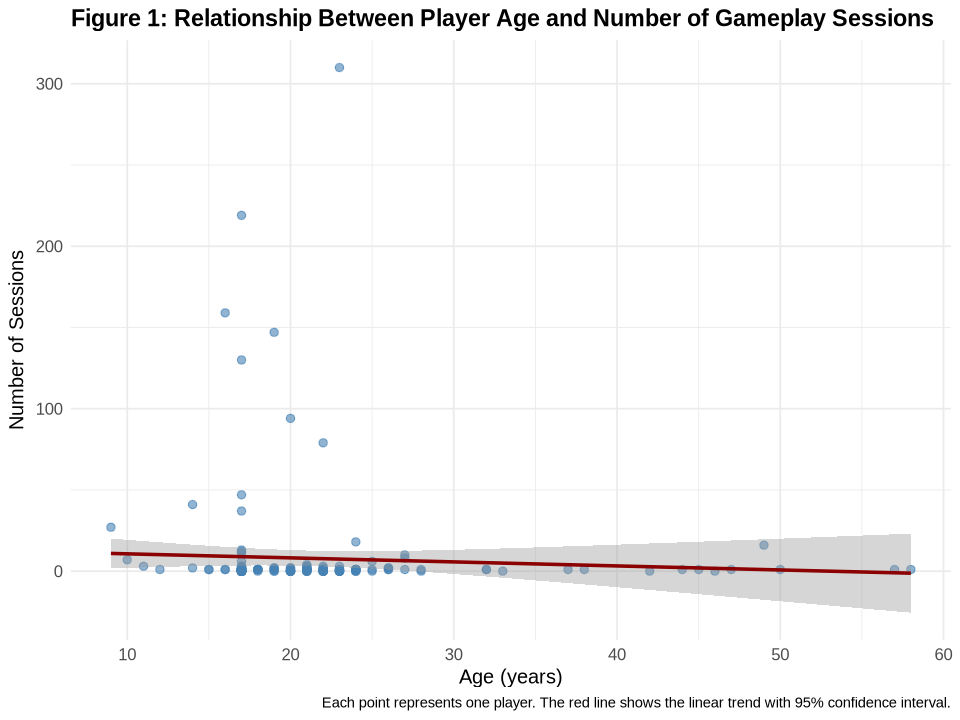

In [17]:
# Set figure size for better readability
options(repr.plot.width = 8, repr.plot.height = 6)

# Create scatter plot with regression line
ggplot(analysis_data, aes(x = Age, y = num_sessions)) +
  geom_point(alpha = 0.6, color = "steelblue", size = 2) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", linewidth = 1) +
  labs(
    title = "Figure 1: Relationship Between Player Age and Number of Gameplay Sessions",
    x = "Age (years)",
    y = "Number of Sessions",
    caption = "Each point represents one player. The red line shows the linear trend with 95% confidence interval."
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

Figure 1 shows the relationship between player age and the number of gameplay sessions contributed to the research server. Most players cluster near the bottom of the plot with fewer than 25 sessions, regardless of age. The nearly horizontal regression line (with a slight negative slope) indicates a very weak relationship between age and session count. 

While there are some notable outliers, particularly younger players (ages 15-25) with over 100 sessions, these high-engagement players appear across various ages. The wide confidence interval around the regression line further suggests substantial variability and uncertainty in predicting sessions based solely on age. This visual evidence supports our earlier finding from the correlation analysis that age may not be a strong predictor of player contribution to the research dataset.

## KNN Regression Analysis

In [22]:
set.seed(2000)

analysis_split <- initial_split(analysis_data, prop = 0.75, strata = num_sessions)
analysis_training <- training(analysis_split)
analysis_testing <- testing(analysis_split)

analysis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")

analysis_recipe <- recipe(num_sessions ~ Age, data = analysis_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

analysis_vfold <- vfold_cv(analysis_training, v = 5, strata = num_sessions)

analysis_workflow <- workflow() |>
    add_recipe(analysis_recipe) |>
    add_model(analysis_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

analysis_results <- analysis_workflow |>
    tune_grid(resamples = analysis_vfold, grid = gridvals) |>
    collect_metrics() 

analysis_min <- analysis_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)

k_min <- analysis_min |>
         pull(neighbors)

analysis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

analysis_best_fit <- workflow() |>
         add_recipe(analysis_recipe) |>
         add_model(analysis_best_spec) |>
         fit(data = analysis_training)

analysis_summary <- analysis_best_fit |>
          predict(analysis_testing) |>
          bind_cols(analysis_testing) |>
          metrics(truth = num_sessions, estimate = .pred)

## KNN Plot Visualization

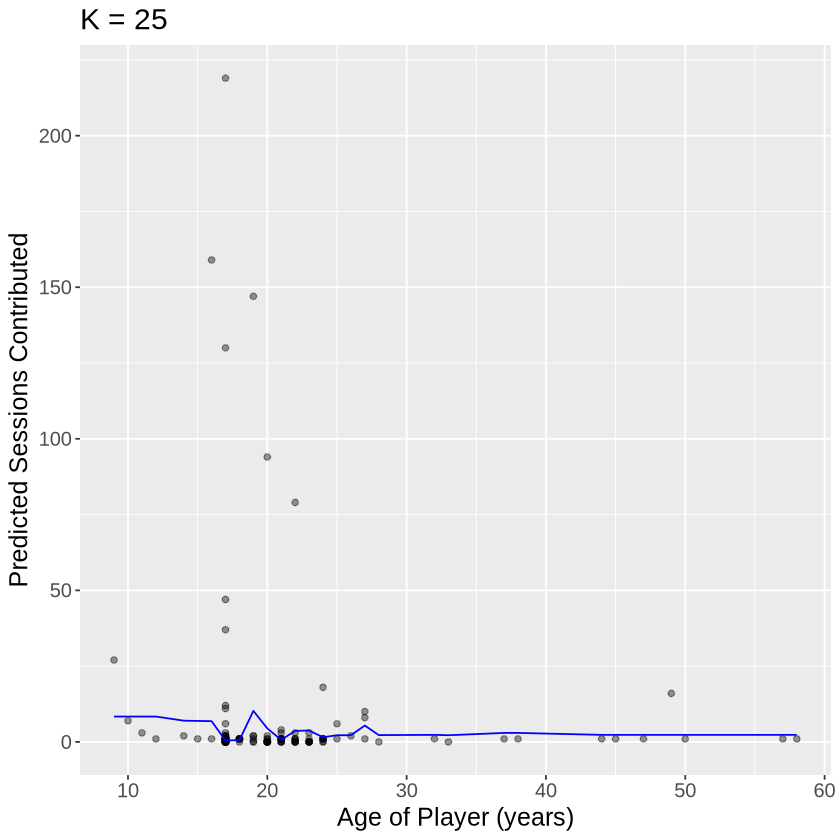

In [23]:
options(repr.plot.width = 7, repr.plot.height = 7)

analysis_preds <- analysis_best_fit |>
    predict(analysis_training) |>
    bind_cols(analysis_training)

analysis_plot <- analysis_preds |>
    ggplot(aes(x = Age, y = num_sessions)) +

    geom_point(alpha = 0.4) +

    geom_line(aes(x = Age, y = .pred), color = "blue") + 

    labs(y = "Predicted Sessions Contributed", 
         x = "Age of Player (years)", 
         title = paste0("K = ", k_min)) +
         theme(text = element_text(size = 15))

analysis_plot

### Analysis among lower ages (Age <30)

In [20]:
set.seed(2000)

low_age_data <- analysis_data |>
    # filter(Age < 30) |>
    filter(num_sessions > 0)

low_age_split <- initial_split(low_age_data, prop = 0.75, strata = num_sessions)
low_age_training <- training(low_age_split)
low_age_testing <- testing(low_age_split)

low_age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")

low_age_recipe <- recipe(num_sessions ~ Age, data = low_age_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

low_age_vfold <- vfold_cv(low_age_training, v = 5, strata = num_sessions)

low_age_workflow <- workflow() |>
    add_recipe(low_age_recipe) |>
    add_model(low_age_spec)

low_age_gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

low_age_results <- low_age_workflow |>
    tune_grid(resamples = low_age_vfold, grid = low_age_gridvals) |>
    collect_metrics() 

low_age_min <- low_age_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)

low_age_k_min <- low_age_min |>
         pull(neighbors)

low_age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = low_age_k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

low_age_best_fit <- workflow() |>
         add_recipe(low_age_recipe) |>
         add_model(low_age_best_spec) |>
         fit(data = low_age_training)

low_age_summary <- low_age_best_fit |>
          predict(low_age_testing) |>
          bind_cols(low_age_testing) |>
          metrics(truth = num_sessions, estimate = .pred)

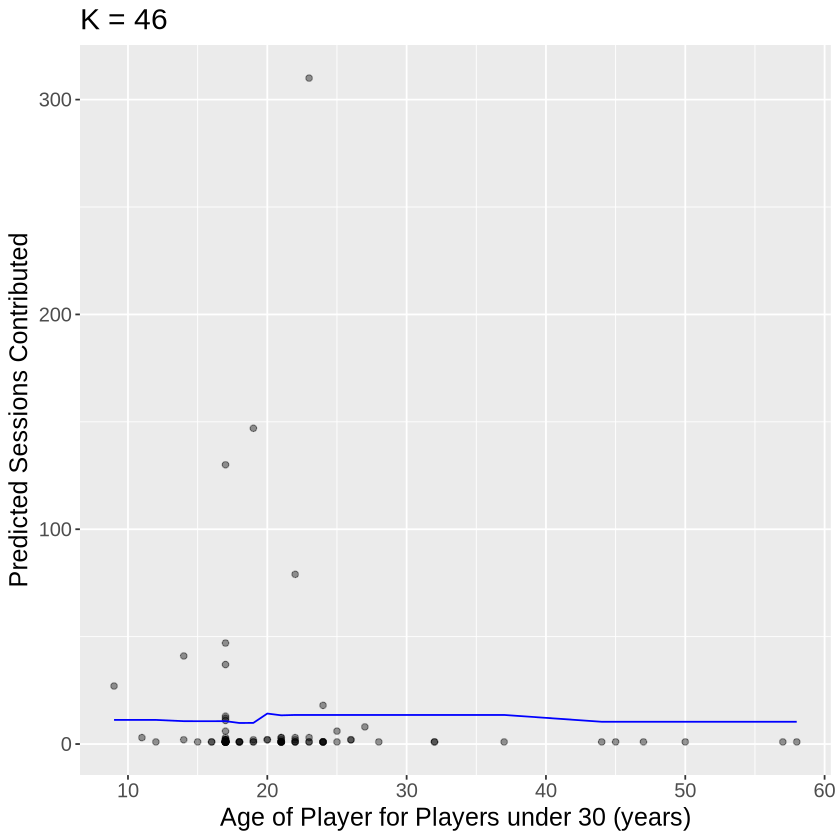

In [21]:
options(repr.plot.width = 7, repr.plot.height = 7)

low_age_preds <- low_age_best_fit |>
    predict(low_age_training) |>
    bind_cols(low_age_training)

low_age_plot <- low_age_preds |>
    ggplot(aes(x = Age, y = num_sessions)) +

    geom_point(alpha = 0.4) +

    geom_line(aes(x = Age, y = .pred), color = "blue") + 

    labs(y = "Predicted Sessions Contributed", 
         x = "Age of Player for Players under 30 (years)", 
         title = paste0("K = ", low_age_k_min)) +
         theme(text = element_text(size = 15))

low_age_plot

## Discussion
### Findings Summary
- summarize what you found (Zoelle)

### Expected Findings
- discuss whether this is what you expected to find (Zoelle)

### Discussing Potential Impacts of Findings
- discuss what impact could such findings have 

### Future Questions
- future questions could this lead to 

## References
- You may include references if necessary, as long as they all have a consistent citation style.